In [278]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import random
from time import gmtime, strftime

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import shap

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [279]:
train = pd.read_csv('fraudTrain.csv')
test  = pd.read_csv('fraudTest.csv')

In [280]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [281]:
def calc_distance(lat1, long1, lat2, long2):
    """Определение дистанции между точками
    """
    R = 6373.0 # approximate radius of earth in km
    lat1 = radians(lat1)
    lon1 = radians(long1)
    lat2 = radians(lat2)
    lon2 = radians(long2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [282]:
def preprocess_features_basic(df):
    """Функция добавляет к датафрейму аттрибуты:
    - trans_hour     - час транзакции;
    - trans_week_day - день недели транзакции;
    - birth_year     - год рождения плательщика
    - trans_distance - дистанция между местом жительства плательщика и местом транзакции
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: trans_hour, trans_dttm, dob, trans_week_day')
    df['trans_hour'] = df['trans_date_trans_time'].str[11:13]
    df['trans_dttm'] = pd.to_datetime(df['trans_date_trans_time'])
    df['birth_year'] = df['dob'].str[0:4].astype('int')
    df['trans_week_day'] = df['trans_dttm'].apply(lambda x: x.strftime('%A'))
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: trans_distance')
    df['trans_distance'] = df.apply(lambda row: calc_distance(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis = 1)
    return df

In [272]:
def get_feature_str(feature_name, target_name, df):
    """Определяем количество и долю единичек для аттрибута. 
    Функция возвращает датафрейм из 3х колонок: 
    наименование аттрибута, количество единичек, долю единичек для каждого значения аттрибута
    """
    agg_df = df.groupby([feature_name,target_name], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    pivot_df = agg_df.pivot(index=feature_name, columns=target_name).fillna(0)
    flat_df = pd.DataFrame(pivot_df.to_records())
    flat_df.columns = [feature_name, 'target_0', 'target_1']
    flat_df['target_share'] = flat_df['target_1'] / (flat_df['target_0'] + flat_df['target_1'])
    flat_df.sort_values(by='target_share', ascending=False, inplace = True)
    flat_df.columns = [feature_name, feature_name + '_target_0_cnt', feature_name + '_target_1_cnt', feature_name + '_target_share']
    flat_df = flat_df.drop(feature_name + '_target_0_cnt', axis = 1)
    return flat_df

In [273]:
def preprocess_features_references(train, test = None, type_cd = 'train', min_typical_trans_cnt = 400):
    """Функция добавляет к датафрейму аттбируты на основании справочников, полученных из обучающей выборки:
    - life_time_days - количество дней между первой транзакцией плательщика и текущей ("время жизни плательника")
    - typical_zip    - признак того, что код локации является типовым, т.е. в нем совершено большое количество (>400) нефродовых транзакций  
    - typical_job    - признак того, что должность является типовой, т.е. для нее совершено большое количество (>400) нефродовых транзакций  
    - merchant_target_share - доля фродовых транзакций у получателя платежа
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess_features_references: zip, job, cc_num, merchant')
    zip_df = train.loc[train['is_fraud']==0,:].groupby(['zip','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    typical_zip = list(zip_df.loc[zip_df['cnt']>min_typical_trans_cnt,:]['zip'])
    job_df = train.loc[train['is_fraud']==0,:].groupby(['job','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    typical_job = list(job_df.loc[job_df['cnt']>min_typical_trans_cnt,:]['job'])
    fraudster = list(train.loc[train['is_fraud']==1,:].groupby(['cc_num','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})['cc_num'])
    cc_num_min_time = train.groupby(['cc_num'], as_index=False)\
            .aggregate({'unix_time' : 'min'})\
            .rename(columns = {'unix_time': 'first_trans_time'})
    merchant_fraud_share = get_feature_str('merchant', 'is_fraud', train)
    merchant_fraud_share.drop('merchant_target_1_cnt', axis = 1, inplace = True)
    def mark_typical_features(df,typical_zip,typical_job):
        df['typical_zip'] = df['zip'].isin(typical_zip).astype(int)
        df['typical_job'] = df['job'].isin(typical_job).astype(int)
        df['earlier_fraudster'] = df['cc_num'].isin(fraudster).astype(int)
        df = df.merge(cc_num_min_time, on='cc_num', how='left')
        df['life_time_days'] = df['unix_time'] - df['first_trans_time']
        df['life_time_days'].fillna(0, inplace = True)
        df['life_time_days'] = df['life_time_days'] / (60*60*24)
        df['life_time_days'] = df['life_time_days'].apply(lambda x: x + random.uniform(0.05,0.5))
        df['life_time_days'] = df['life_time_days'].round(3)
        df = df.merge(merchant_fraud_share, on='merchant', how='left')
        df['merchant_target_share'].fillna(0, inplace = True)
        return df
    if type_cd == 'train':
        train = mark_typical_features(train,typical_zip,typical_job)
        return train
    if type_cd == 'test':
        test = mark_typical_features(test,typical_zip,typical_job)
        return test

In [274]:
def delete_unwanted_features(df):
    """ Удалим лишние аттрибуты
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Deleting unwanted features')
    features_to_delete = ['Unnamed: 0',
                          'trans_date_trans_time',
                          'cc_num',
                          'merchant',
                          'first',
                          'last',
                          'street',
                          'city',
                          'state',
                          'zip',
                          'lat',
                          'long',
                          'job',
                          'dob',
                          'trans_num',
                          'unix_time',
                          'merch_lat',
                          'merch_long',
                          'trans_dttm',
                          'first_trans_time']
    df.drop(features_to_delete, axis = 1, inplace = True)
    return df

In [275]:
def one_hot_encode(df, col_name):
    """ Функция выполняет one hot encoding по списку аттрибутов
    """
    for i in list(col_name):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' One hot encoding: ' + i)
        one_hot = pd.get_dummies(df[i])
        one_hot.columns = i + '_' + one_hot.columns
        df = df.drop(i, axis = 1)
        df = df.join(one_hot)
    return df

In [277]:
train_1 = preprocess_features_basic(train)
train_2 = preprocess_features_references(train = train_1, type_cd = 'train')
train_3 = delete_unwanted_features(train_2)
train_4 = one_hot_encode(train_3, ['category','gender','trans_hour', 'trans_week_day'])

2020-11-10 16:00:53 Preprocess features: person_name, trans_hour, trans_dttm, dob, trans_week_day
2020-11-10 16:01:12 Preprocess features: trans_distance
2020-11-10 16:02:46 Preprocess_features_references: zip, job, cc_num, merchant
2020-11-10 16:02:54 Deleting unwanted features
2020-11-10 16:03:08 One hot encoding: category
2020-11-10 16:03:09 One hot encoding: gender
2020-11-10 16:03:10 One hot encoding: trans_hour
2020-11-10 16:03:10 One hot encoding: trans_week_day


In [227]:
test_1 = preprocess_features_basic(test)
test_2 = preprocess_features_references(train = train_1, test = test_1, type_cd = 'test')
test_3 = delete_unwanted_features(test_2)
test_4 = one_hot_encode(test_3, ['category','gender','trans_hour', 'trans_week_day'])

2020-11-10 13:51:04 Preprocess features: person_name, trans_hour, trans_dttm, dob, trans_week_day
2020-11-10 13:51:11 Preprocess features: trans_distance
2020-11-10 13:51:54 Preprocess_features_references: zip, job, cc_num, merchant
2020-11-10 13:51:59 Deleting unwanted_features
2020-11-10 13:52:00 One hot encoding: category
2020-11-10 13:52:00 One hot encoding: gender
2020-11-10 13:52:00 One hot encoding: trans_hour
2020-11-10 13:52:01 One hot encoding: trans_week_day


# Train model

In [253]:
X = train_4.drop('is_fraud', axis = 1)
y = train_4.loc[:,'is_fraud']

In [260]:
model = XGBClassifier(nthread=-1, learning_rate=0.1) #, n_estimators=1000)

In [261]:
model.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.96      0.77      0.85      7506

    accuracy                           1.00   1296675
   macro avg       0.98      0.89      0.93   1296675
weighted avg       1.00      1.00      1.00   1296675

[[1288916     253]
 [   1718    5788]]


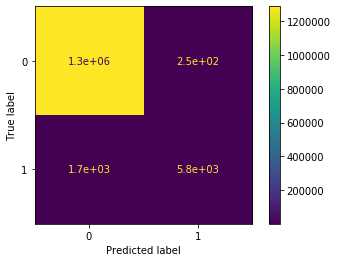

In [262]:
# summarize the fit of the model
expected = y
predicted = model.predict(X)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

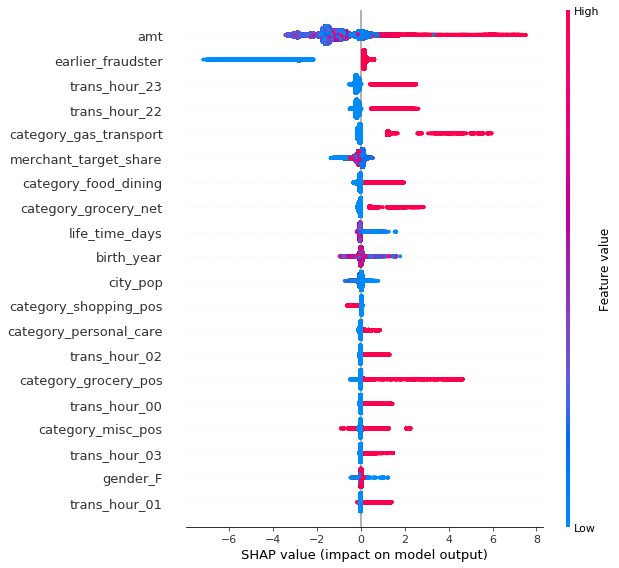

In [265]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

# Test model

In [244]:
X = test_4.drop('is_fraud', axis = 1)
y = test_4.loc[:,'is_fraud']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.19      0.02      0.04      2145

    accuracy                           1.00    555719
   macro avg       0.59      0.51      0.52    555719
weighted avg       0.99      1.00      0.99    555719

[[553347    227]
 [  2093     52]]


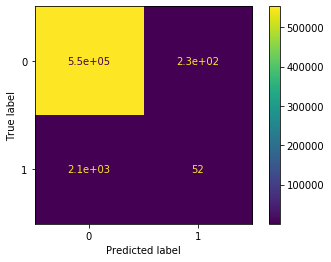

In [245]:
# summarize the fit of the model
expected = y
predicted = model.predict(X)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

# :(